# Classifying Images as Birds or Airplanes


**Dataset:** https://www.cs.toronto.edu/~kriz/cifar.html<br>


## Import required libraries

PyTorch for building and training the neural network.

In [90]:
import torch

Torchvision

In [91]:
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset


Numpy for data manipulation and preprocessing

In [92]:
import matplotlib.pyplot as plt

In [93]:
import numpy as np

## Data Pre-processing

### Loading the data

First we load the train and test dataset from the CIFAR-10:

In [94]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Now we can view the properties of the datasets we have imported:

In [95]:
print("Train-set size:", len(trainset))
print("Test-set size:", len(testset))
print("Classes: ", trainset.classes)

Train-set size: 50000
Test-set size: 10000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


As the CIFAR-10 dataset has already sorted the dataset into training and testing automatically we do not need to worry about this. It has a test to train ratio of 5:1

### Filtering the data

As we can see, this dataset currently consists of 10 seperate classes, while we only want to classify between airplanes and birds. For this reason, we will filter out the other classes.

In [96]:
#0 and 2 correspond to the index of the 'airplane' and 'bird' classes
filtered_classes = [0, 2]

train_indices = [i for i, label in enumerate(trainset.targets) if label in filtered_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in filtered_classes]

trainset_filtered = torch.utils.data.Subset(trainset, train_indices)
testset_filtered = torch.utils.data.Subset(testset, test_indices)

Upon filtering the dataset, we can view the properties of the new subset below. Notice how the train and test sets have shrunk to 20% of the original size, as we have removed the 80% we are not using.

In [97]:
print("Train-set size:", len(trainset_filtered))
print("Test-set size:", len(testset_filtered))
print([trainset.classes[i] for i in filtered_classes])


Train-set size: 10000
Test-set size: 2000
['airplane', 'bird']


### Viewing the data

Next we can observe the images and labels in this dataset to ensure that it is working as expected.

Bird label: 2


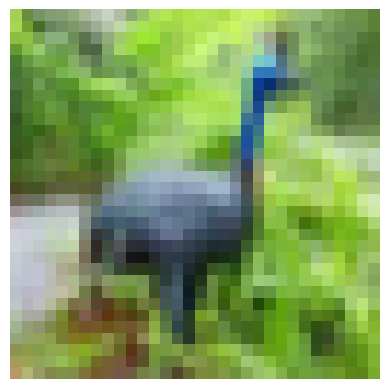

Plane label: 0


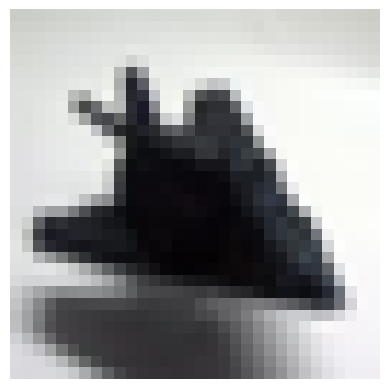

In [98]:
#1st bird in the data set
print("Bird label:", trainset_filtered[0][1])
plt.imshow(trainset_filtered[0][0])
plt.axis('off')
plt.show()

#1st plane in the dataset
print("Plane label:", trainset_filtered[4][1])
plt.imshow(trainset_filtered[4][0])
plt.axis('off')
plt.show()


As we can see label 2 is linked with the bird label, and label 0 is linked with the planes image, as expected.

### Transforming the data

Now we must transform the data because [INSERT REASON, something about preparing it to be modelled]. We first turn the data into a NumPy array and then we normalise it to the range 0-1. This is not necessary with out image data, as our images have a pixel rating from 0-255 but it has advantages such as faster training that make it worth doing. [SOURCE: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/]

In [99]:
#Using float32 for efficiency
train_images = np.array([image for image, label in trainset_filtered], dtype=np.float32)
test_images = np.array([image for image, label in testset_filtered], dtype=np.float32)

train_images /= 255.0
test_images /= 255.0


### Creating dataloaders

Next we must create dataloaders, so we can have an iterable over our dataset:

In [100]:
trainloader = torch.utils.data.DataLoader(trainset_filtered, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset_filtered, batch_size=4, shuffle=False, num_workers=4)


We shuffle the data in our training dataset. This is to make sure that the model doesn't learn anything from the order of images input. This isn't necessary with our testing dataset however, so we can leave this false. 
Num_workers relates to the number seperate workers that will load the data in parallel. While a high number of workers may speed up performance, it may also increase memory utilisation so its good to strike a balance.
We are also using a batch size of 4. A larger batch size can be good for speed, but too high and we risk lower accuracy and overfitting.

## Defining the Model

Next we must define a model, which we are doing with a Convolutional Neural Network as these are very good for classifying images.

In [101]:
class Model(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
